## Naive Baseline 

Processing dataset for 7-day prediction using naive baseline
Loading data...
Test set contains 7 unique dates.

Sample of last training prices (5 random listings):
        listing_id last_train_date  last_train_price
          18443229      2024-02-08         -0.676506
          21263004      2024-02-08         -0.674629
609116710769468723      2024-02-08          0.243201
           1143342      2024-02-08         -0.354609
565095645322286011      2024-02-08          1.741009


Processing days: 100%|██████████| 7/7 [00:26<00:00,  3.85s/it]


Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results.csv with location data
Daily metrics saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results_daily_metrics.csv

===== NAIVE BASELINE MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.0689
MAE: 0.0180
R²: 0.9943
MAPE: 18.6871%

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.085992 0.028172 34.919231       7864
2024-02-10 0.066181 0.014452  6.618084       7864
2024-02-11 0.093244 0.033602 28.977065       7864
2024-02-12 0.056354 0.012064  5.929106       7864
2024-02-13 0.036243 0.006701  4.398428       7864
2024-02-14 0.052710 0.013720 15.023759       7864
2024-02-15 0.074110 0.017149 34.944139       7864

=== Performance Statistics ===
MAE:
  Average: 0.0180
  Min: 0.0067 (Day: 2024-02-13 00:00:00)
  Max: 0.0336 (Day: 2024-02-11 00:00:00)

RMSE:
  Average: 0.0664
  Min: 0.0362 (Day: 2024-02-13 00

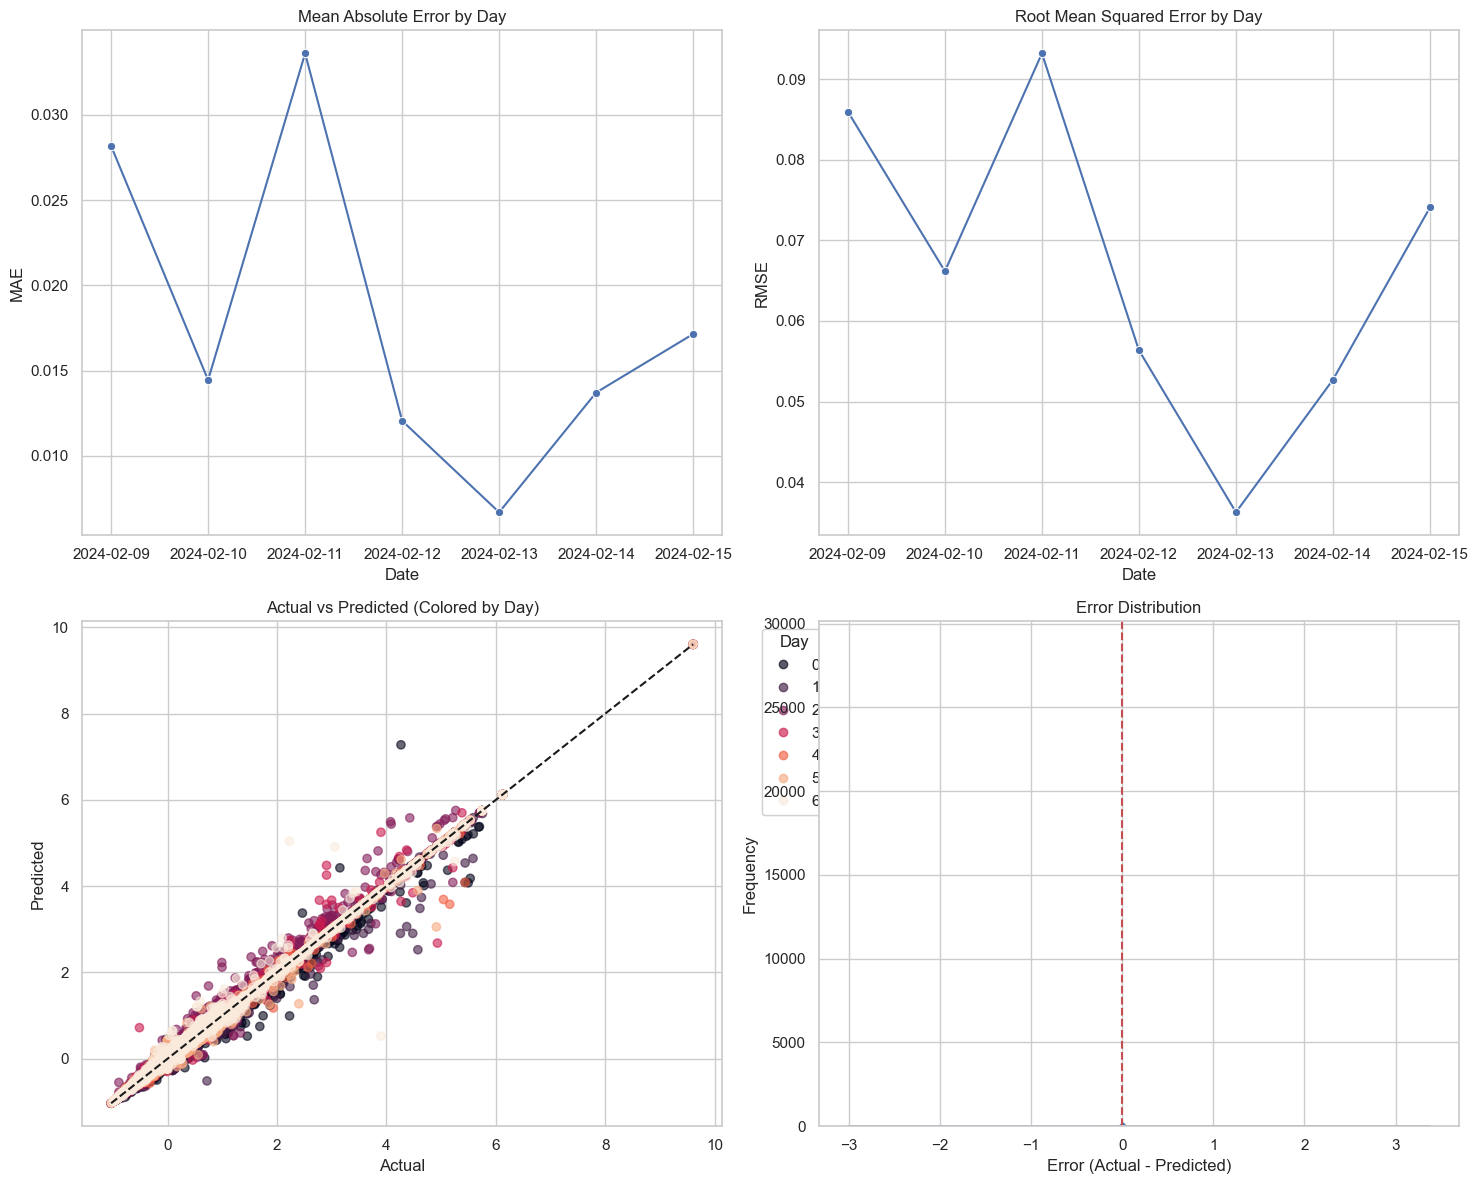

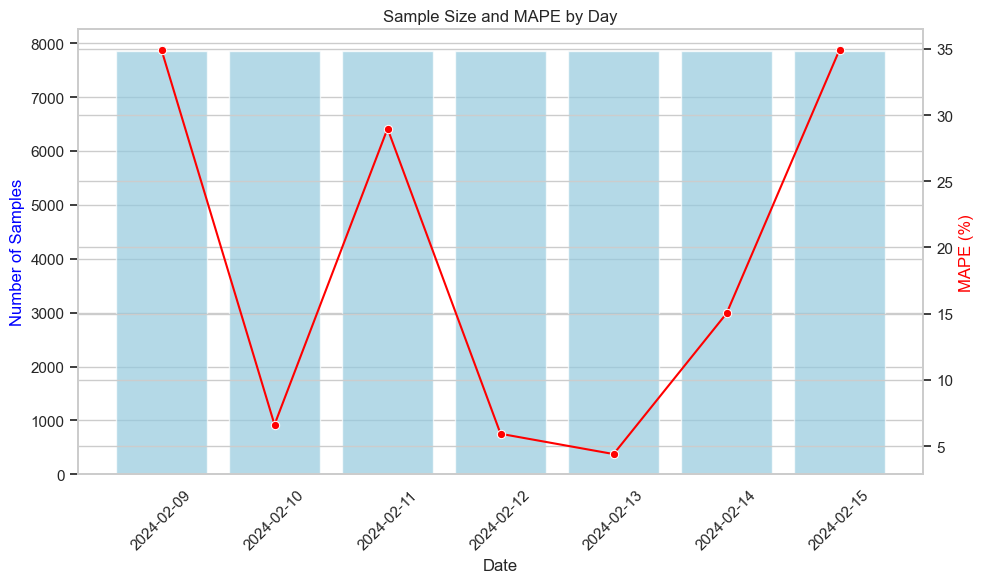

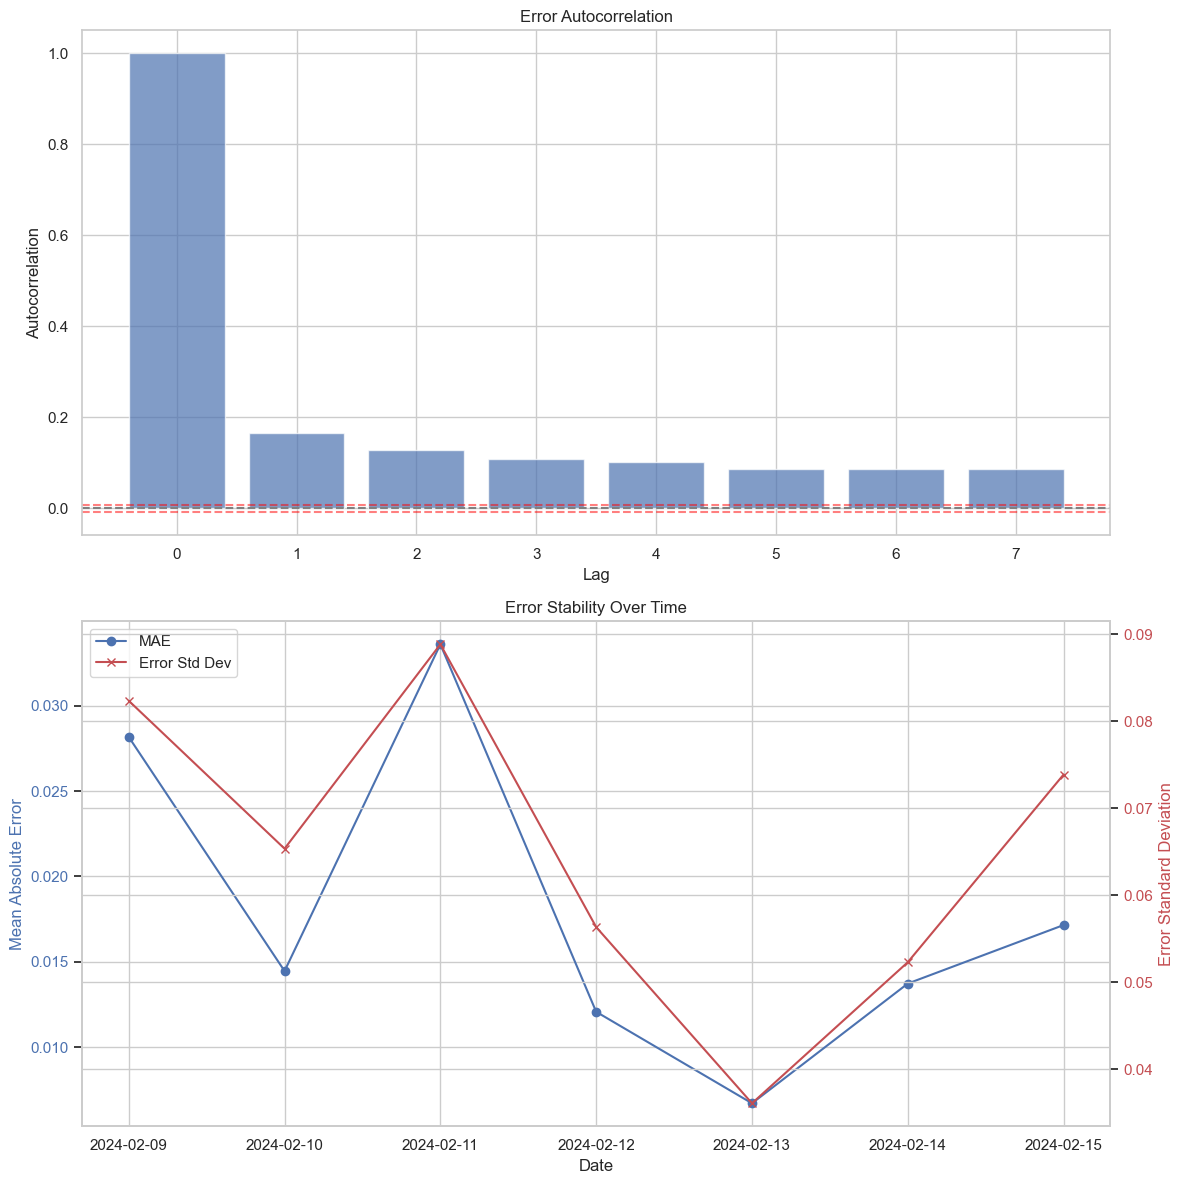


Naive baseline analysis complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
from datetime import timedelta
import os  # Added for directory handling

# Set the style for plots
sns.set_theme(style="whitegrid")

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_naive_baseline_prediction(train_path, test_path, prediction_days=7, output_path=None):
    """
    Run naive baseline model that predicts the previous day's price
    for a 7-day horizon.
    
    Parameters:
    train_path (str): Path to training data CSV
    test_path (str): Path to test data CSV
    prediction_days (int): Number of days to predict
    output_path (str, optional): Path to save results CSV. If None, results won't be saved.
    """
    print(f"Processing dataset for {prediction_days}-day prediction using naive baseline")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Sort by date
    train_data = train_data.sort_values(['listing_id', 'date'])
    test_data = test_data.sort_values(['listing_id', 'date'])
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Get the last price from training data for each listing
    last_train_prices = train_data.groupby('listing_id').last()[['date', 'price']].reset_index()
    last_train_prices.rename(columns={'date': 'last_train_date', 'price': 'last_train_price'}, inplace=True)
    
    # Print some sample of last training prices
    print("\nSample of last training prices (5 random listings):")
    print(last_train_prices.sample(min(5, len(last_train_prices))).to_string(index=False))
    
    # Initialize results storage
    day_results = []
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Merge with last known prices
        day_test = day_test.merge(last_train_prices, on='listing_id', how='left')
        
        # Check for missing last_train_price values
        missing_prices = day_test[day_test['last_train_price'].isna()]
        if len(missing_prices) > 0:
            print(f"Warning: {len(missing_prices)} listings on {day} don't have a training price. Using mean price.")
            # Fill with mean price
            mean_price = train_data['price'].mean()
            day_test['last_train_price'] = day_test['last_train_price'].fillna(mean_price)
        
        # Calculate naive predictions (use last training price)
        day_test['predicted'] = day_test['last_train_price']
        
        # Calculate errors
        day_test['error'] = day_test['price'] - day_test['predicted']
        day_test['abs_error'] = np.abs(day_test['error'])
        day_test['pct_error'] = (np.abs(day_test['error']) / day_test['price']) * 100
        
        # Store results for the day
        day_results.append(day_test[['date', 'listing_id', 'price', 'predicted', 'error', 'abs_error', 'pct_error', 'last_train_date']])
        
        # Update last known prices for next day prediction
        # This simulates getting actual values at the end of each day
        new_last_prices = day_test[['listing_id', 'date', 'price']].copy()
        new_last_prices.rename(columns={'date': 'last_train_date', 'price': 'last_train_price'}, inplace=True)
        
        # Update the last known prices
        for _, row in new_last_prices.iterrows():
            idx = last_train_prices['listing_id'] == row['listing_id']
            if any(idx):
                last_train_prices.loc[idx, 'last_train_date'] = row['last_train_date']
                last_train_prices.loc[idx, 'last_train_price'] = row['last_train_price']
            else:
                # Add this listing if it wasn't in the training data
                last_train_prices = pd.concat([last_train_prices, pd.DataFrame([row])], ignore_index=True)
    
    # Combine all daily results
    all_results = pd.concat(day_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in day_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['price'].values
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)

    # Add to evaluation results
    evaluation_results['error_autocorrelation'] = error_autocorrelation
    evaluation_results['error_stability'] = error_stability
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data from test data if available
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save daily metrics
        metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")

    return evaluation_results

def plot_results(evaluation_results):
    """Plot the results from predictions"""
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== NAIVE BASELINE MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

# Main execution
if __name__ == "__main__":
    # Specify paths to your data
    train_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\train.csv"
    test_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_price_changers_subset\test_feb.csv"
    
    # Specify output path for results CSV
    output_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results.csv"
    
    # Run naive baseline prediction for 7 days and save results
    results = run_naive_baseline_prediction(
        train_path=train_path,
        test_path=test_path,
        prediction_days=7,
        output_path=output_path  # Added this parameter
    )
    
    # Print summary and plot results
    print_summary(results)
    plot_results(results)
    plot_error_analysis(results)
    
    # Print completion message
    print("\nNaive baseline analysis complete.")

## Spatial Analysis

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

def load_data(results_path, geojson_path, listings_path=None):
    """Load and prepare all data needed for analysis"""
    print("Loading data...")
    
    # Load results
    results_df = pd.read_csv(results_path)
    
    # Check if results have coordinates
    if 'longitude' not in results_df.columns or 'latitude' not in results_df.columns:
        print("Results file does not contain coordinates. Loading from listings...")
        if listings_path:
            # Load listings data to get coordinates
            listings_df = pd.read_csv(listings_path)
            location_data = listings_df[['id', 'longitude', 'latitude']].rename(columns={'id': 'listing_id'})
            results_df = results_df.merge(location_data, on='listing_id', how='left')
        else:
            raise ValueError("Cannot find coordinates and no listings path provided")
    
    # Load neighborhood boundaries
    neighborhoods = gpd.read_file(geojson_path)
    
    # Convert results to GeoDataFrame
    # Remove any rows with NaN coordinates
    results_df = results_df.dropna(subset=['longitude', 'latitude'])
    
    # Convert coordinates to float if not already
    results_df['longitude'] = results_df['longitude'].astype(float)
    results_df['latitude'] = results_df['latitude'].astype(float)
    
    # Create geometry
    geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
    results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
    
    return results_df, results_gdf, neighborhoods

def assign_neighborhoods(results_gdf, neighborhoods):
    """Assign neighborhoods to each listing using spatial join"""
    print("Assigning neighborhoods to listings...")
    
    # Make sure CRS match
    if neighborhoods.crs != results_gdf.crs:
        print(f"Converting CRS: {neighborhoods.crs} to {results_gdf.crs}")
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # Try different spatial join approaches
    try:
        # For newer GeoPandas versions
        joined = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # For older GeoPandas versions
            joined = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback - try exact match method
            print("Trying manual neighborhood assignment...")
            joined = results_gdf.copy()
            joined['neighbourhood'] = None
            
            for idx, row in results_gdf.iterrows():
                point = row.geometry
                for n_idx, n_row in neighborhoods.iterrows():
                    if point.within(n_row.geometry):
                        joined.at[idx, 'neighbourhood'] = n_row['neighbourhood']
                        break
    
    # Check for neighborhood column
    neighborhood_columns = [col for col in joined.columns if 'neighbo' in col.lower()]
    if neighborhood_columns:
        if 'neighbourhood' not in neighborhood_columns:
            joined['neighbourhood'] = joined[neighborhood_columns[0]]
        
        # Print summary of assignment
        assigned = joined['neighbourhood'].notna().sum()
        total = len(joined)
        print(f"Assigned {assigned} out of {total} listings ({assigned/total*100:.1f}%) to neighborhoods")
    else:
        print("No neighborhood column found! Creating dummy neighborhood.")
        joined['neighbourhood'] = 'Unknown'
    
    return joined

def calculate_neighborhood_metrics(results_with_neighborhoods):
    """Calculate metrics for each neighborhood"""
    print("Calculating neighborhood metrics...")
    
    # Group by neighborhood and calculate metrics
    try:
        metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
            'abs_error': 'mean',
            'error': ['mean', 'std'],
            'price': 'mean',
            'pct_error': 'mean',
            'listing_id': 'count'  # count listings per neighborhood
        })
        
        # Fix column names
        metrics.columns = ['mae', 'mean_error', 'std_error', 'mean_price', 'mape', 'count']
        
        # Sort by count and remove neighborhoods with too few listings
        metrics = metrics.sort_values('count', ascending=False)
        small_neighborhoods = metrics[metrics['count'] < 5].index
        if len(small_neighborhoods) > 0:
            print(f"Removing {len(small_neighborhoods)} neighborhoods with fewer than 5 listings")
            metrics = metrics[metrics['count'] >= 5]
        
        return metrics
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        # Return dummy metrics
        return pd.DataFrame({
            'mae': [results_with_neighborhoods['abs_error'].mean()],
            'mean_error': [results_with_neighborhoods['error'].mean()],
            'std_error': [results_with_neighborhoods['error'].std()],
            'mean_price': [results_with_neighborhoods['price'].mean()],
            'mape': [results_with_neighborhoods['pct_error'].mean()],
            'count': [len(results_with_neighborhoods)]
        }, index=['All Paris'])

def plot_error_maps(results_gdf, neighborhoods, output_dir):
    """Create static maps showing error distribution"""
    print("Creating error maps...")
    os.makedirs(output_dir, exist_ok=True)
    
    # Create maps for absolute error and signed error
    for error_type, title in [
        ('abs_error', 'Absolute Prediction Error'),
        ('error', 'Signed Prediction Error (+ = Overestimated, - = Underestimated)'),
        ('pct_error', 'Percentage Error')
    ]:
        try:
            # Convert to web mercator for contextily
            results_projected = results_gdf.to_crs(epsg=3857)
            neighborhoods_projected = neighborhoods.to_crs(epsg=3857)
            
            # Create figure
            fig, ax = plt.subplots(figsize=(15, 15))
            
            # Plot neighborhood boundaries
            neighborhoods_projected.boundary.plot(ax=ax, linewidth=1, color='gray')
            
            # Choose appropriate colormap based on error type
            cmap = 'RdYlGn_r' if error_type == 'abs_error' or error_type == 'pct_error' else 'RdBu_r'
            
            # Plot error points
            results_projected.plot(
                column=error_type,
                ax=ax,
                alpha=0.6,
                markersize=10,
                legend=True,
                cmap=cmap
            )
            
            # Add basemap
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
            
            # Set title and style
            ax.set_title(title, fontsize=16)
            ax.set_axis_off()
            
            # Save figure
            output_path = os.path.join(output_dir, f'{error_type}_map.png')
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"Saved map to {output_path}")
            
        except Exception as e:
            print(f"Error creating {error_type} map: {e}")

def visualize_neighborhood_performance(metrics, output_dir):
    """Create visualizations of neighborhood performance"""
    print("Creating neighborhood performance visualizations...")
    os.makedirs(output_dir, exist_ok=True)
    
    # Save metrics to CSV
    metrics.to_csv(os.path.join(output_dir, 'neighborhood_metrics.csv'))
    
    # Plot MAE by neighborhood (top 15)
    try:
        plt.figure(figsize=(12, 8))
        top_n = min(15, len(metrics))
        sorted_metrics = metrics.sort_values('mae')
        plot_data = sorted_metrics.iloc[:top_n]
        
        sns.barplot(x=plot_data.index, y=plot_data['mae'])
        plt.title('Mean Absolute Error by Neighborhood (Top 15)')
        plt.xlabel('Neighborhood')
        plt.ylabel('Mean Absolute Error')
        plt.xticks(rotation=90)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'neighborhood_mae.png'), dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating neighborhood MAE plot: {e}")
    
    # Plot MAPE vs Average Price
    try:
        plt.figure(figsize=(10, 8))
        plt.scatter(metrics['mean_price'], metrics['mape'], alpha=0.7, s=metrics['count']/5)
        
        # Add labels for top and bottom 5 neighborhoods by MAPE
        top_5 = metrics.sort_values('mape', ascending=True).head(5)
        bottom_5 = metrics.sort_values('mape', ascending=False).head(5)
        
        for idx, row in pd.concat([top_5, bottom_5]).iterrows():
            plt.annotate(idx, (row['mean_price'], row['mape']), fontsize=8)
        
        plt.title('Price Error vs. Average Price by Neighborhood')
        plt.xlabel('Average Price')
        plt.ylabel('Mean Absolute Percentage Error (%)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'price_vs_error.png'), dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating price vs error plot: {e}")
    
    # Plot correlation matrix
    try:
        corr = metrics.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Between Neighborhood Metrics')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'metric_correlation.png'), dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error creating correlation matrix: {e}")

def create_price_cluster_map(results_gdf, neighborhoods, output_dir):
    """Identify spatial clusters of similar price patterns"""
    print("Creating price cluster analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Extract coordinates for clustering
        coords = results_gdf[['latitude', 'longitude']].values
        
        # Standardize coordinates
        coords_scaled = StandardScaler().fit_transform(coords)
        
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=0.1, min_samples=5).fit(coords_scaled)
        
        # Add cluster labels to the GeoDataFrame
        results_gdf['price_cluster'] = dbscan.labels_
        
        # Prepare for plotting
        results_projected = results_gdf.to_crs(epsg=3857)
        neighborhoods_projected = neighborhoods.to_crs(epsg=3857)
        
        # Create map
        fig, ax = plt.subplots(figsize=(15, 15))
        
        # Plot neighborhood boundaries
        neighborhoods_projected.boundary.plot(ax=ax, linewidth=1, color='gray')
        
        # Plot clusters
        results_projected.plot(
            column='price_cluster', 
            categorical=True,
            legend=True,
            markersize=10,
            alpha=0.6,
            ax=ax
        )
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
        
        # Set title and style
        ax.set_title('Price Clusters in Paris', fontsize=16)
        ax.set_axis_off()
        
        # Save figure
        output_path = os.path.join(output_dir, 'price_clusters.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved price cluster map to {output_path}")
        
        # Calculate metrics by cluster
        cluster_metrics = results_gdf.groupby('price_cluster').agg({
            'abs_error': 'mean',
            'error': ['mean', 'std'],
            'price': 'mean',
            'pct_error': 'mean',
            'listing_id': 'count'
        })
        
        cluster_metrics.columns = ['mae', 'mean_error', 'std_error', 'mean_price', 'mape', 'count']
        cluster_metrics.to_csv(os.path.join(output_dir, 'cluster_metrics.csv'))
        
    except Exception as e:
        print(f"Error in price cluster analysis: {e}")

def main():
    """Main execution function"""
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results.csv"
    listings_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\listings.csv"
    geojson_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\neighbourhoods.geojson"
    
    # Create output directory
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\spatial_analysis"
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Load data
        results_df, results_gdf, neighborhoods = load_data(
            results_path=results_path,
            geojson_path=geojson_path,
            listings_path=listings_path
        )
        
        # Assign neighborhoods to results
        results_with_neighborhoods = assign_neighborhoods(results_gdf, neighborhoods)
        
        # Calculate neighborhood metrics
        neighborhood_metrics = calculate_neighborhood_metrics(results_with_neighborhoods)
        
        # Create visualizations
        plot_error_maps(results_with_neighborhoods, neighborhoods, output_dir)
        visualize_neighborhood_performance(neighborhood_metrics, output_dir)
        create_price_cluster_map(results_with_neighborhoods, neighborhoods, output_dir)
        
        print(f"Spatial analysis complete. All results saved to {output_dir}")
        
    except Exception as e:
        print(f"Error in spatial analysis: {e}")

if __name__ == "__main__":
    main()

Loading data...
Assigning neighborhoods to listings...
Used 'predicate' parameter for spatial join
Assigned 55048 out of 55048 listings (100.0%) to neighborhoods
Calculating neighborhood metrics...
Creating error maps...
Saved map to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\spatial_analysis\abs_error_map.png
Saved map to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\spatial_analysis\error_map.png
Saved map to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\spatial_analysis\pct_error_map.png
Creating neighborhood performance visualizations...
Creating price cluster analysis...
Saved price cluster map to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\spatial_analysis\price_clusters.png
Spatial analysis complete. All results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\spatial_analysis


In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
import warnings
warnings.filterwarnings('ignore')

def run_simple_spatial_analysis(results_path, geojson_path, output_dir):
    """
    Run a simple spatial analysis to gain insights from prediction errors
    
    Parameters:
    results_path: Path to the naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running simple spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Create GeoDataFrame from results
    if 'longitude' in results_df.columns and 'latitude' in results_df.columns:
        geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
        results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
        print(f"Created GeoDataFrame with {len(results_gdf)} points")
    else:
        raise ValueError("Results file missing longitude/latitude coordinates")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with 'predicate' (newer geopandas)
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with 'op' (older geopandas)
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Simple fallback
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            
            # Find the neighborhood column name
            neighborhood_col = None
            for col in neighborhoods.columns:
                if 'neighbo' in col.lower():
                    neighborhood_col = col
                    break
            
            if not neighborhood_col:
                print("Warning: No neighborhood column found in GeoJSON")
                neighborhood_col = 'neighbourhood'
            
            # Add empty neighborhood column
            results_with_neighborhoods[neighborhood_col] = None
    
    # 5. Standardize neighborhood column name
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Find neighborhood column among the joined columns
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
            print(f"Using column '{neighborhood_cols[0]}' as neighborhood identifier")
        else:
            print("Warning: Could not identify neighborhood column")
            results_with_neighborhoods['neighbourhood'] = "Unknown"
    
    # 6. Calculate neighborhood-level metrics
    print("Calculating neighborhood metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'abs_error': 'mean',
        'error': 'mean',
        'pct_error': 'mean',
        'price': 'mean',
        'listing_id': 'count'
    }).rename(columns={
        'abs_error': 'mae', 
        'error': 'mean_error',
        'pct_error': 'mape',
        'price': 'mean_price',
        'listing_id': 'count'
    })
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['count'] >= min_listings].copy()
    
    # 7. Create maps and visualizations
    print("Creating visualizations...")
    
    # 7.1 Create choropleth map of MAE by neighborhood
    create_choropleth_map(
        neighborhoods, 
        filtered_metrics, 
        'mae', 
        'Mean Absolute Error by Neighborhood',
        os.path.join(output_dir, 'mae_by_neighborhood.png')
    )
    
    # 7.2 Create choropleth map of MAPE by neighborhood
    create_choropleth_map(
        neighborhoods, 
        filtered_metrics, 
        'mape', 
        'Mean Percentage Error by Neighborhood (%)',
        os.path.join(output_dir, 'mape_by_neighborhood.png')
    )
    
    # 7.3 Create scatter plot of error vs listings density
    plt.figure(figsize=(10, 6))
    plt.scatter(
        filtered_metrics['count'], 
        filtered_metrics['mae'],
        alpha=0.7, 
        s=80
    )
    
    # Add labels for notable neighborhoods
    for idx, row in filtered_metrics.iterrows():
        # Label neighborhoods with many listings or high/low errors
        if (row['count'] > filtered_metrics['count'].quantile(0.75) or 
            row['mae'] > filtered_metrics['mae'].quantile(0.75) or
            row['mae'] < filtered_metrics['mae'].quantile(0.25)):
            plt.annotate(
                idx, 
                (row['count'], row['mae']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8
            )
    
    plt.title('Error vs. Number of Listings by Neighborhood')
    plt.xlabel('Number of Listings')
    plt.ylabel('Mean Absolute Error')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'error_vs_listings.png'), dpi=300)
    plt.close()
    
    # 7.4 Create scatter plot of error vs average price
    plt.figure(figsize=(10, 6))
    plt.scatter(
        filtered_metrics['mean_price'], 
        filtered_metrics['mae'],
        alpha=0.7, 
        s=80
    )
    
    # Add labels for notable neighborhoods
    for idx, row in filtered_metrics.iterrows():
        # Label neighborhoods with high prices or high/low errors
        if (row['mean_price'] > filtered_metrics['mean_price'].quantile(0.75) or 
            row['mae'] > filtered_metrics['mae'].quantile(0.75) or
            row['mae'] < filtered_metrics['mae'].quantile(0.25)):
            plt.annotate(
                idx, 
                (row['mean_price'], row['mae']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8
            )
    
    plt.title('Error vs. Average Price by Neighborhood')
    plt.xlabel('Average Price')
    plt.ylabel('Mean Absolute Error')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'error_vs_price.png'), dpi=300)
    plt.close()
    
    # 8. Create table of best and worst performing neighborhoods
    best_neighborhoods = filtered_metrics.sort_values('mae').head(5)
    worst_neighborhoods = filtered_metrics.sort_values('mae', ascending=False).head(5)
    
    performance_summary = pd.concat([
        best_neighborhoods.reset_index(),
        worst_neighborhoods.reset_index()
    ])
    performance_summary['category'] = ['Best'] * 5 + ['Worst'] * 5
    performance_summary = performance_summary[['category', 'neighbourhood', 'mae', 'mape', 'mean_price', 'count']]
    
    # Save to CSV
    performance_summary.to_csv(os.path.join(output_dir, 'neighborhood_performance.csv'), index=False)
    
    # 9. Print key insights
    print("\n--- KEY INSIGHTS FROM SPATIAL ANALYSIS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Best performing neighborhood: {best_neighborhoods.index[0]} (MAE = {best_neighborhoods['mae'].iloc[0]:.4f})")
    print(f"Worst performing neighborhood: {worst_neighborhoods.index[0]} (MAE = {worst_neighborhoods['mae'].iloc[0]:.4f})")
    
    # Calculate correlation between price and error
    price_error_corr = filtered_metrics['mean_price'].corr(filtered_metrics['mae'])
    print(f"Correlation between neighborhood average price and MAE: {price_error_corr:.4f}")
    
    # Calculate correlation between listing count and error
    count_error_corr = filtered_metrics['count'].corr(filtered_metrics['mae'])
    print(f"Correlation between neighborhood listing count and MAE: {count_error_corr:.4f}")
    
    print(f"Results saved to {output_dir}")
    
    return neighborhood_metrics

def create_choropleth_map(neighborhoods, metrics, column, title, output_path):
    """Create a simple choropleth map"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create the map
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Choose appropriate colormap
    cmap = 'Reds' if column in ['mae', 'mape'] else 'viridis'
    
    # Plot choropleth
    map_data.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Add title and styling
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results.csv"
    geojson_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\simple_spatial_analysis"
    
    # Run analysis
    run_simple_spatial_analysis(results_path, geojson_path, output_dir)

Running simple spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood metrics...
Creating visualizations...

--- KEY INSIGHTS FROM SPATIAL ANALYSIS ---
Total neighborhoods analyzed: 20
Best performing neighborhood: Ménilmontant (MAE = 0.0048)
Worst performing neighborhood: Louvre (MAE = 0.0435)
Correlation between neighborhood average price and MAE: 0.8710
Correlation between neighborhood listing count and MAE: -0.1504
Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\simple_spatial_analysis


In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

def run_enhanced_spatial_analysis(results_path, geojson_path, output_dir):
    """
    Run an enhanced spatial analysis with clear, actionable insights
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running enhanced spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Create GeoDataFrame from results
    if 'longitude' in results_df.columns and 'latitude' in results_df.columns:
        # Clean data - remove rows with missing coordinates
        results_df = results_df.dropna(subset=['longitude', 'latitude'])
        
        # Convert coordinates to float if needed
        results_df['longitude'] = results_df['longitude'].astype(float)
        results_df['latitude'] = results_df['latitude'].astype(float)
        
        # Create geometry
        geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
        results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
        print(f"Created GeoDataFrame with {len(results_gdf)} points")
    else:
        raise ValueError("Results file missing longitude/latitude coordinates")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['index_right'] = None
            results_with_neighborhoods['neighbourhood'] = None
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate distance to city center (in kilometers)
    paris_center = Point(2.3522, 48.8566)  # Approximate center of Paris
    results_with_neighborhoods['dist_to_center_km'] = results_with_neighborhoods.geometry.apply(
        lambda x: paris_center.distance(x) * 111.32  # Approximate conversion to km
    )
    
    # 7. Calculate neighborhood-level metrics
    print("Calculating neighborhood metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'abs_error': ['mean', 'median', 'std'],
        'error': ['mean', 'std'],
        'pct_error': ['mean', 'std'],
        'price': ['mean', 'median', 'std', 'count'],
        'dist_to_center_km': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'abs_error_mean': 'mae',
        'abs_error_median': 'median_abs_error',
        'abs_error_std': 'error_volatility',
        'pct_error_mean': 'mape',
        'price_count': 'listing_count',
        'dist_to_center_km_mean': 'avg_distance_to_center'
    })
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 8. Create comprehensive spatial visualizations
    print("Creating visualizations...")
    
    # 8.1 Create main error map with key insights
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'mae', 
        'Mean Absolute Error by Neighborhood',
        os.path.join(output_dir, 'error_map.png')
    )
    
    # 8.2 Create map showing bias (over/under prediction)
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_mean', 
        'Prediction Bias by Neighborhood (+ = Underestimated, - = Overestimated)',
        os.path.join(output_dir, 'bias_map.png'),
        cmap='RdBu'
    )
    
    # 8.3 Create map showing error volatility
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_volatility', 
        'Error Volatility by Neighborhood',
        os.path.join(output_dir, 'volatility_map.png')
    )
    
    # 8.4 Create multi-panel analysis of key relationships
    create_multi_panel_analysis(filtered_metrics, os.path.join(output_dir, 'spatial_relationships.png'))
    
    # 8.5 Create scatterplot matrix
    create_scatterplot_matrix(filtered_metrics, os.path.join(output_dir, 'scatterplot_matrix.png'))
    
    # 9. Calculate error vs distance relationship
    dist_error_corr, dist_error_p = pearsonr(
        results_with_neighborhoods['dist_to_center_km'],
        results_with_neighborhoods['abs_error']
    )
    
    # 10. Create distance vs error analysis
    create_distance_analysis(
        results_with_neighborhoods,
        os.path.join(output_dir, 'distance_analysis.png')
    )
    
    # 11. Cluster neighborhoods by error patterns
    n_clusters = min(5, len(filtered_metrics))
    cluster_features = ['mae', 'error_mean', 'mape', 'price_mean', 'avg_distance_to_center']
    
    # Scale the data for clustering
    from sklearn.preprocessing import StandardScaler
    X = filtered_metrics[cluster_features].copy()
    X = StandardScaler().fit_transform(X)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    filtered_metrics['cluster'] = kmeans.fit_predict(X)
    
    # Create neighborhood cluster map
    create_cluster_map(
        neighborhoods,
        filtered_metrics,
        os.path.join(output_dir, 'neighborhood_clusters.png')
    )
    
    # 12. Create neighborhood performance table
    # Table of best and worst neighborhoods
    best_neighborhoods = filtered_metrics.sort_values('mae').head(5)
    worst_neighborhoods = filtered_metrics.sort_values('mae', ascending=False).head(5)
    
    performance_table = pd.concat([
        best_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']],
        worst_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    ])
    performance_table['category'] = ['Best'] * 5 + ['Worst'] * 5
    performance_table = performance_table[['category', 'neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    
    # Save to CSV
    performance_table.to_csv(os.path.join(output_dir, 'neighborhood_performance.csv'), index=False)
    
    # Save all metrics
    filtered_metrics.to_csv(os.path.join(output_dir, 'all_neighborhood_metrics.csv'))
    
    # 13. Print key insights
    print("\n--- KEY SPATIAL INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Best performing neighborhood: {best_neighborhoods.index[0]} (MAE = {best_neighborhoods['mae'].iloc[0]:.4f})")
    print(f"Worst performing neighborhood: {worst_neighborhoods.index[0]} (MAE = {worst_neighborhoods['mae'].iloc[0]:.4f})")
    
    # Calculate correlations between metrics
    corr = filtered_metrics[['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']].corr()
    
    # Print key correlations
    print("\n--- KEY CORRELATIONS ---")
    print(f"Price vs Error (MAE): {corr.loc['price_mean', 'mae']:.4f}")
    print(f"Distance to Center vs Error: {corr.loc['avg_distance_to_center', 'mae']:.4f}")
    print(f"Listing Count vs Error: {corr.loc['listing_count', 'mae']:.4f}")
    
    # Direct distance-error relationship from points
    print(f"Point-level Distance-Error Correlation: {dist_error_corr:.4f} (p-value: {dist_error_p:.4f})")
    
    # Interpret key findings
    print("\n--- INTERPRETATION ---")
    
    # Price-error relationship
    price_corr = corr.loc['price_mean', 'mae']
    if abs(price_corr) > 0.7:
        print(f"Very strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
        if price_corr > 0:
            print("- Higher-priced neighborhoods have significantly larger prediction errors")
            print("- Model struggles most with luxury/premium areas")
        else:
            print("- Higher-priced neighborhoods have significantly lower prediction errors")
            print("- Model performs better in premium/luxury areas")
    elif abs(price_corr) > 0.5:
        print(f"Strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    elif abs(price_corr) > 0.3:
        print(f"Moderate {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    else:
        print(f"Weak correlation between price and error ({price_corr:.2f})")
        print("- Neighborhood price level is not a strong predictor of model performance")
    
    # Distance-error relationship
    dist_corr = corr.loc['avg_distance_to_center', 'mae']
    if abs(dist_corr) > 0.5:
        print(f"\nStrong {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
        if dist_corr > 0:
            print("- Neighborhoods further from the city center have larger prediction errors")
            print("- Model performs worse in peripheral areas")
        else:
            print("- Central neighborhoods have larger prediction errors")
            print("- Model performs better in peripheral areas")
    elif abs(dist_corr) > 0.3:
        print(f"\nModerate {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
    else:
        print(f"\nWeak correlation between distance to center and error ({dist_corr:.2f})")
        print("- Location relative to city center doesn't strongly affect prediction accuracy")
    
    # Bias analysis (over/under prediction)
    avg_error = filtered_metrics['error_mean'].mean()
    if abs(avg_error) > 0.05:
        bias_direction = "underestimates" if avg_error > 0 else "overestimates"
        print(f"\nThe model generally {bias_direction} prices (average error: {avg_error:.4f})")
        
        # Check if bias is consistent across neighborhoods
        bias_std = filtered_metrics['error_mean'].std()
        if bias_std < abs(avg_error) * 0.5:
            print("- This bias is fairly consistent across neighborhoods")
        else:
            most_under = filtered_metrics.sort_values('error_mean', ascending=False).index[0]
            most_over = filtered_metrics.sort_values('error_mean', ascending=True).index[0]
            print(f"- Bias varies considerably by neighborhood")
            print(f"- Most underestimated neighborhood: {most_under}")
            print(f"- Most overestimated neighborhood: {most_over}")
    
    print(f"\nResults saved to {output_dir}")
    
    return {
        'neighborhood_metrics': filtered_metrics,
        'correlations': corr,
        'distance_correlation': dist_error_corr
    }

def create_error_map(neighborhoods, metrics, column, title, output_path, cmap='Reds'):
    """Create a detailed choropleth map with key insights"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create the map
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'label': column.replace('_', ' ').title(),
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.05
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Label top 3 and bottom 3 neighborhoods
    if column in metrics.columns:
        # Top 3 highest values
        top3 = metrics.sort_values(column, ascending=False).head(3)
        for idx, row in top3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
        
        # Top 3 lowest values
        bottom3 = metrics.sort_values(column).head(3)
        for idx, row in bottom3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
    
    # Add title and styling
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    
    # Add key statistics box
    if column in metrics.columns:
        corr_with_price = metrics[[column, 'price_mean']].corr().iloc[0, 1]
        corr_with_dist = metrics[[column, 'avg_distance_to_center']].corr().iloc[0, 1]
        
        stats_text = (
            f"Correlation with price: {corr_with_price:.2f}\n"
            f"Correlation with distance: {corr_with_dist:.2f}\n"
            f"Best area: {metrics[column].idxmin()}\n"
            f"Worst area: {metrics[column].idxmax()}"
        )
        
        # Place text box in bottom right
        plt.figtext(
            0.92, 0.05, 
            stats_text,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=10,
            ha='right'
        )
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_multi_panel_analysis(metrics, output_path):
    """Create a multi-panel figure showing key spatial relationships"""
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    # Panel 1: Price vs. Error
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(
        x='price_mean',
        y='mae',
        size='listing_count',
        hue='avg_distance_to_center',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax1
    )
    
    # Add correlation
    corr = metrics[['price_mean', 'mae']].corr().iloc[0, 1]
    ax1.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['price_mean'] > metrics['price_mean'].mean() + 1.5 * metrics['price_mean'].std()):
            ax1.annotate(
                idx,
                (row['price_mean'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax1.set_title('Price vs. Error by Neighborhood', fontsize=14)
    ax1.set_xlabel('Average Price', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Distance vs. Error
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        x='avg_distance_to_center',
        y='mae',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax2
    )
    
    # Add correlation
    corr = metrics[['avg_distance_to_center', 'mae']].corr().iloc[0, 1]
    ax2.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['avg_distance_to_center'] > metrics['avg_distance_to_center'].mean() + 1.5 * metrics['avg_distance_to_center'].std()):
            ax2.annotate(
                idx,
                (row['avg_distance_to_center'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax2.set_title('Distance from Center vs. Error', fontsize=14)
    ax2.set_xlabel('Average Distance from City Center (km)', fontsize=12)
    ax2.set_ylabel('Mean Absolute Error', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Error vs. Error Volatility
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(
        x='mae',
        y='error_volatility',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax3
    )
    
    # Add correlation
    corr = metrics[['mae', 'error_volatility']].corr().iloc[0, 1]
    ax3.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['error_volatility'] > metrics['error_volatility'].mean() + 1.5 * metrics['error_volatility'].std()):
            ax3.annotate(
                idx,
                (row['mae'], row['error_volatility']),
                fontsize=9,
                alpha=0.8
            )
    
    ax3.set_title('Error vs. Error Volatility', fontsize=14)
    ax3.set_xlabel('Mean Absolute Error', fontsize=12)
    ax3.set_ylabel('Error Volatility (Std Dev)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Bias Analysis (Error Mean)
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create a centered colormap for bias
    error_mean_data = metrics['error_mean']
    max_abs_error = max(abs(error_mean_data.min()), abs(error_mean_data.max()))
    error_norm = plt.Normalize(-max_abs_error, max_abs_error)
    
    scatter = ax4.scatter(
        metrics['price_mean'],
        metrics['avg_distance_to_center'],
        s=metrics['listing_count'] * 2,
        c=metrics['error_mean'],
        cmap='RdBu_r',
        norm=error_norm,
        alpha=0.7
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Prediction Bias (+ = Underestimated, - = Overestimated)', fontsize=10)
    
    # Label neighborhoods with extreme bias
    for idx, row in metrics.iterrows():
        if (abs(row['error_mean']) > abs(metrics['error_mean']).mean() + 1.5 * abs(metrics['error_mean']).std()):
            ax4.annotate(
                idx,
                (row['price_mean'], row['avg_distance_to_center']),
                fontsize=9,
                alpha=0.8
            )
    
    ax4.set_title('Prediction Bias by Price and Location', fontsize=14)
    ax4.set_xlabel('Average Price', fontsize=12)
    ax4.set_ylabel('Distance from City Center (km)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle('Spatial Patterns in Prediction Errors', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_scatterplot_matrix(metrics, output_path):
    """Create a scatterplot matrix of key metrics"""
    # Select features for the matrix
    features = ['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']
    
    # Create scatterplot matrix
    sns.set(style="ticks")
    sns.pairplot(
        metrics[features],
        diag_kind="kde",
        plot_kws={"alpha": 0.6}
    )
    
    plt.suptitle('Relationships Between Key Neighborhood Metrics', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_distance_analysis(results_gdf, output_path):
    """Create detailed analysis of distance-error relationship"""
    # Create distance bins
    max_dist = results_gdf['dist_to_center_km'].max()
    results_gdf['dist_bin'] = pd.cut(
        results_gdf['dist_to_center_km'],
        bins=10,
        include_lowest=True,
        labels=False
    )
    
    # Calculate stats by distance bin
    dist_stats = results_gdf.groupby('dist_bin').agg({
        'dist_to_center_km': ['mean', 'count'],
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'price': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    dist_stats.columns = ['_'.join(col).strip('_') for col in dist_stats.columns.values]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot distance vs error
    ax1.errorbar(
        dist_stats['dist_to_center_km_mean'],
        dist_stats['abs_error_mean'],
        yerr=dist_stats['abs_error_std'],
        fmt='o-',
        capsize=5,
        ecolor='gray',
        alpha=0.7
    )
    
    # Add sample size as text
    for i, row in dist_stats.iterrows():
        ax1.annotate(
            f"n={int(row['dist_to_center_km_count'])}",
            (row['dist_to_center_km_mean'], row['abs_error_mean']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            fontsize=8
        )
    
    # Add correlation line
    x = results_gdf['dist_to_center_km']
    y = results_gdf['abs_error']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(np.sort(x.unique()), p(np.sort(x.unique())), "r--", alpha=0.7)
    
    # Calculate correlation
    corr, p_value = pearsonr(x, y)
    ax1.annotate(
        f"Correlation: {corr:.2f} (p={p_value:.4f})",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    ax1.set_title('Error vs. Distance from City Center', fontsize=14)
    ax1.set_xlabel('Distance from Center (km)', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Create spatial visualization of error by distance
    # Project to Web Mercator for mapping
    results_projected = results_gdf.to_crs('EPSG:3857')
    paris_center_projected = gpd.GeoDataFrame([1], geometry=[Point(2.3522, 48.8566)], crs="EPSG:4326").to_crs('EPSG:3857')
    
    # Plot on map
    scatter = ax2.scatter(
        results_projected.geometry.x,
        results_projected.geometry.y,
        c=results_projected['abs_error'],
        cmap='hot_r',
        alpha=0.6,
        s=20
    )
    
    # Add center point
    ax2.scatter(
        paris_center_projected.geometry.x,
        paris_center_projected.geometry.y,
        marker='*',
        s=300,
        color='blue',
        edgecolor='white',
        linewidth=1,
        zorder=10
    )
    
    # Draw distance rings
    for dist_km in [2, 4, 6, 8]:
        # Convert km to meters
        dist_m = dist_km * 1000
        circle = plt.Circle(
            (paris_center_projected.geometry.x, paris_center_projected.geometry.y),
            dist_m,
            fill=False,
            color='gray',
            linestyle='--',
            alpha=0.7
        )
        ax2.add_patch(circle)
        # Add label
        angle = np.pi/4  # 45 degrees
        x = paris_center_projected.geometry.x.iloc[0] + dist_m * np.cos(angle)
        y = paris_center_projected.geometry.y.iloc[0] + dist_m * np.sin(angle)
        ax2.annotate(
            f"{dist_km} km",
            (x, y),
            fontsize=9,
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7)
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Absolute Error', fontsize=12)
    
    # Add basemap
    try:
        ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
    except:
        print("Warning: Could not add basemap to distance analysis")
    
    ax2.set_title('Spatial Distribution of Errors', fontsize=14)
    ax2.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_map(neighborhoods, metrics, output_path):
    """Create a map showing neighborhood clusters based on error patterns"""
    # Join cluster information to neighborhoods
    map_data = neighborhoods.merge(metrics[['cluster']], left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot neighborhoods colored by cluster
    map_data.plot(
        column='cluster',
        categorical=True,
        ax=ax,
        legend=True,
        cmap='tab10',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'title': 'Cluster',
            'loc': 'lower left'
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Create cluster summary statistics
    cluster_stats = metrics.groupby('cluster').agg({
        'mae': 'mean',
        'error_mean': 'mean',
        'mape': 'mean',
        'price_mean': 'mean',
        'avg_distance_to_center': 'mean',
        'listing_count': 'sum'
    })
    
    # Add textbox with cluster characteristics
    cluster_desc = ""
    for cluster, row in cluster_stats.iterrows():
        # Determine key characteristics of this cluster
        price_level = "High" if row['price_mean'] > metrics['price_mean'].mean() else "Low"
        error_level = "High" if row['mae'] > metrics['mae'].mean() else "Low"
        location = "Central" if row['avg_distance_to_center'] < metrics['avg_distance_to_center'].mean() else "Peripheral"
        
        cluster_desc += f"Cluster {cluster}: {price_level} price, {error_level} error, {location}\n"
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        cluster_desc,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    # Add title and styling
    ax.set_title('Neighborhood Clusters Based on Error Patterns', fontsize=14)
    ax.set_axis_off()
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save cluster descriptions to CSV
    cluster_stats.to_csv(os.path.join(os.path.dirname(output_path), 'cluster_characteristics.csv'))

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results.csv"
    geojson_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\enhanced_spatial_analysis"
    
    # Run analysis
    run_enhanced_spatial_analysis(results_path, geojson_path, output_dir)

Running enhanced spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood metrics...
Creating visualizations...

--- KEY SPATIAL INSIGHTS ---
Total neighborhoods analyzed: 20
Best performing neighborhood: Ménilmontant (MAE = 0.0048)
Worst performing neighborhood: Louvre (MAE = 0.0435)

--- KEY CORRELATIONS ---
Price vs Error (MAE): 0.8710
Distance to Center vs Error: -0.3688
Listing Count vs Error: -0.1504
Point-level Distance-Error Correlation: -0.0485 (p-value: 0.0000)

--- INTERPRETATION ---
Very strong positive correlation between price and error (0.87)
- Higher-priced neighborhoods have significantly larger prediction errors
- Model struggles most with luxury/premium areas

Moderate negative correlation between distance to center and error (-0.37)

Results saved to C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\enhanced_spatial_analysis


## Temporal Analysis

Running simple temporal analysis...

--- Error by Day of Week ---
                  mae     error       mape  count
day_of_week                                      
Monday       0.012064  0.000611  -1.765116   7864
Tuesday      0.006701  0.003171   0.097352   7864
Wednesday    0.013720  0.006396  -3.407160   7864
Thursday     0.017149 -0.005776  16.540662   7864
Friday       0.028172  0.024725  19.327767   7864
Saturday     0.014452  0.010356   0.833622   7864
Sunday       0.033602 -0.028301   9.676562   7864


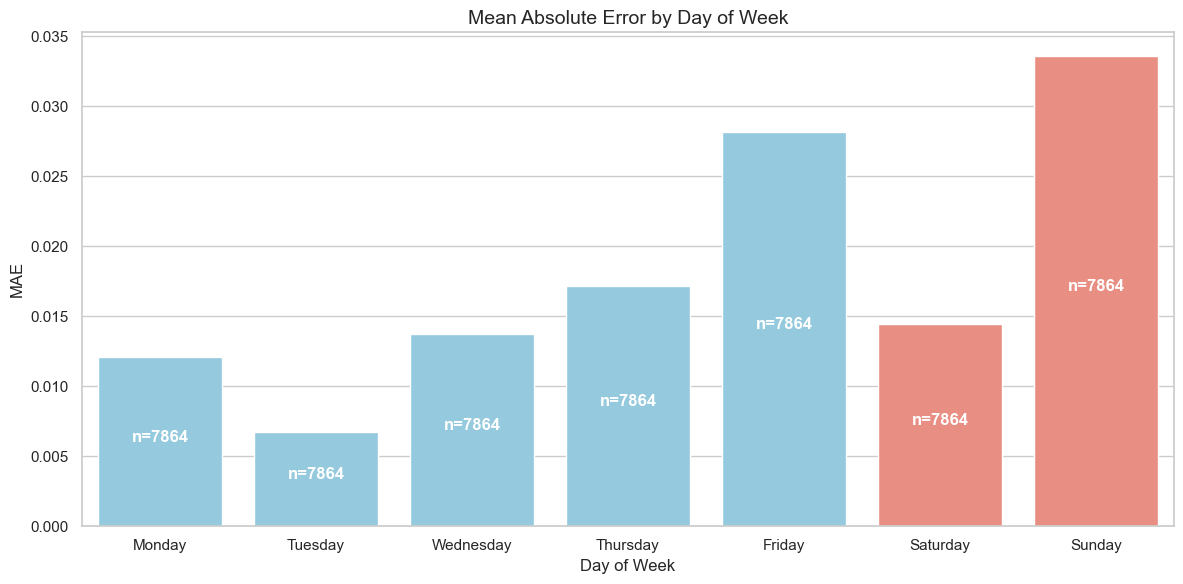


--- Error by Prediction Horizon ---
                         mae     error      mape  count
days_since_training                                    
1                    0.01798  0.001598  5.900527  55048


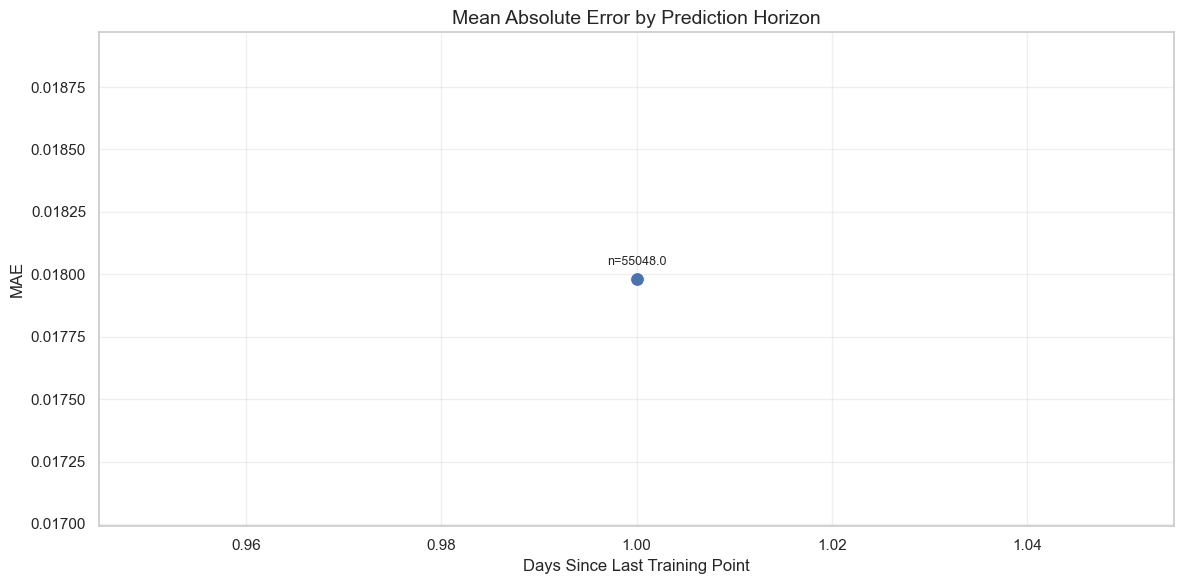

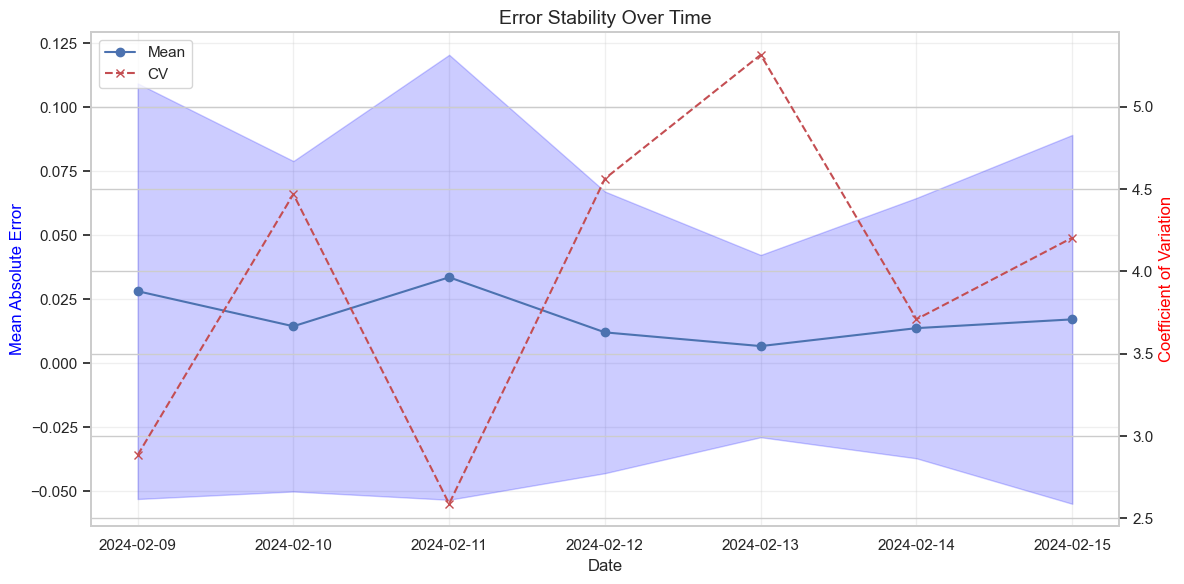


--- KEY TEMPORAL INSIGHTS ---
Weekend vs Weekday Difference: 54.40% higher error on weekends
Correlation between time and error: -0.0660
Best performing day: Tuesday (MAE = 0.0067)
Worst performing day: Sunday (MAE = 0.0336)
Average error volatility (CV): 3.9621
Correlation between prediction horizon and error: nan


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

def run_simple_temporal_analysis(results_path, daily_metrics_path=None, output_dir=None):
    """
    Run a simple temporal analysis to understand how prediction errors vary over time
    
    Parameters:
    results_path: Path to naive baseline results CSV
    daily_metrics_path: Path to daily metrics CSV (if available)
    output_dir: Directory to save output visualizations
    """
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    print("Running simple temporal analysis...")
    
    # Load results data
    results_df = pd.read_csv(results_path)
    
    # Ensure date is in datetime format
    results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract day of week
    results_df['day_of_week'] = results_df['date'].dt.day_name()
    results_df['is_weekend'] = results_df['day_of_week'].isin(['Saturday', 'Sunday'])
    
    # 1. Analyze daily metrics if available
    if daily_metrics_path and os.path.exists(daily_metrics_path):
        daily_df = pd.read_csv(daily_metrics_path)
        daily_df['date'] = pd.to_datetime(daily_df['date'])
        daily_df['day_of_week'] = daily_df['date'].dt.day_name()
        daily_df['is_weekend'] = daily_df['day_of_week'].isin(['Saturday', 'Sunday'])
        
        # Plot daily metrics
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='date', y='mae', data=daily_df, marker='o', markersize=10)
        plt.title('Mean Absolute Error by Day', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add day of week labels
        for i, row in daily_df.iterrows():
            plt.annotate(
                row['day_of_week'][:3],  # First 3 letters of day name
                (row['date'], row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'daily_mae_trend.png'), dpi=300)
        plt.show()
        
        # Compare weekend vs weekday performance
        weekend_stats = daily_df.groupby('is_weekend').agg({
            'mae': 'mean',
            'rmse': 'mean',
            'mape': 'mean'
        })
        
        print("\n--- Weekend vs Weekday Performance ---")
        print(weekend_stats)
        
        # Plot weekend vs weekday comparison
        plt.figure(figsize=(10, 6))
        metrics = ['mae', 'rmse', 'mape']
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.barplot(
                x=weekend_stats.index.map({True: 'Weekend', False: 'Weekday'}), 
                y=metric, 
                data=weekend_stats
            )
            plt.title(metric.upper())
            plt.xlabel('')
            plt.ylabel(metric.upper())
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'weekend_weekday_comparison.png'), dpi=300)
        plt.show()
    
    # 2. Analyze error patterns by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = results_df.groupby('day_of_week').agg({
        'abs_error': 'mean',
        'error': 'mean',
        'pct_error': 'mean',
        'listing_id': 'count'
    }).reindex(day_order).rename(columns={
        'abs_error': 'mae',
        'pct_error': 'mape',
        'listing_id': 'count'
    })
    
    print("\n--- Error by Day of Week ---")
    print(weekday_stats)
    
    # Plot error by day of week
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=weekday_stats.index, 
        y='mae', 
        data=weekday_stats,
        palette=['skyblue' if day not in ['Saturday', 'Sunday'] else 'salmon' for day in weekday_stats.index]
    )
    plt.title('Mean Absolute Error by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    
    # Add count labels
    for i, count in enumerate(weekday_stats['count']):
        plt.text(
            i, 
            weekday_stats['mae'].iloc[i] / 2,
            f"n={count}",
            ha='center',
            color='white',
            fontweight='bold'
        )
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_by_day_of_week.png'), dpi=300)
    plt.show()
    
    # 3. Analyze error trends over prediction horizon
    if 'last_train_date' in results_df.columns:
        # Calculate days since last training point
        results_df['last_train_date'] = pd.to_datetime(results_df['last_train_date'])
        results_df['days_since_training'] = (results_df['date'] - results_df['last_train_date']).dt.days
        
        horizon_stats = results_df.groupby('days_since_training').agg({
            'abs_error': 'mean',
            'error': 'mean',
            'pct_error': 'mean',
            'listing_id': 'count'
        }).rename(columns={
            'abs_error': 'mae',
            'pct_error': 'mape',
            'listing_id': 'count'
        })
        
        print("\n--- Error by Prediction Horizon ---")
        print(horizon_stats)
        
        # Plot error by prediction horizon
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            x=horizon_stats.index, 
            y='mae', 
            data=horizon_stats,
            marker='o',
            markersize=10
        )
        plt.title('Mean Absolute Error by Prediction Horizon', fontsize=14)
        plt.xlabel('Days Since Last Training Point', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add count labels
        for i, row in horizon_stats.iterrows():
            plt.annotate(
                f"n={row['count']}",
                (i, row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'error_by_horizon.png'), dpi=300)
        plt.show()
    
    # 4. Analyze error stability over time
    # Group by date and calculate error statistics
    date_stats = results_df.groupby('date').agg({
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    date_stats.columns = ['_'.join(col).strip('_') for col in date_stats.columns.values]
    
    # Calculate coefficient of variation (measure of relative variability)
    date_stats['error_cv'] = date_stats['abs_error_std'] / date_stats['abs_error_mean']
    
    # Plot error stability
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot mean and std
    ax1.plot(date_stats.index, date_stats['abs_error_mean'], 'b-', marker='o', label='Mean')
    ax1.fill_between(
        date_stats.index,
        date_stats['abs_error_mean'] - date_stats['abs_error_std'],
        date_stats['abs_error_mean'] + date_stats['abs_error_std'],
        alpha=0.2,
        color='blue'
    )
    
    # Plot coefficient of variation
    ax2.plot(date_stats.index, date_stats['error_cv'], 'r--', marker='x', label='CV')
    
    # Add styling
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', color='blue', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation', color='red', fontsize=12)
    plt.title('Error Stability Over Time', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_stability.png'), dpi=300)
    plt.show()
    
    # 5. Calculate key insights
    # Check for weekday-weekend difference
    weekend_mean = results_df[results_df['is_weekend']]['abs_error'].mean()
    weekday_mean = results_df[~results_df['is_weekend']]['abs_error'].mean()
    weekend_diff = ((weekend_mean - weekday_mean) / weekday_mean) * 100
    
    # Check for trend over time (correlation between date and error)
    date_nums = (results_df['date'] - results_df['date'].min()).dt.days
    time_corr = np.corrcoef(date_nums, results_df['abs_error'])[0, 1]
    
    # Print key insights
    print("\n--- KEY TEMPORAL INSIGHTS ---")
    print(f"Weekend vs Weekday Difference: {weekend_diff:.2f}% {'higher' if weekend_diff > 0 else 'lower'} error on weekends")
    print(f"Correlation between time and error: {time_corr:.4f}")
    
    # Identify best and worst days
    best_day = weekday_stats['mae'].idxmin()
    worst_day = weekday_stats['mae'].idxmax()
    print(f"Best performing day: {best_day} (MAE = {weekday_stats.loc[best_day, 'mae']:.4f})")
    print(f"Worst performing day: {worst_day} (MAE = {weekday_stats.loc[worst_day, 'mae']:.4f})")
    
    # Check error volatility
    cv_mean = date_stats['error_cv'].mean()
    print(f"Average error volatility (CV): {cv_mean:.4f}")
    
    if 'days_since_training' in results_df.columns:
        # Check if error grows with prediction horizon
        horizon_corr = np.corrcoef(
            results_df['days_since_training'], 
            results_df['abs_error']
        )[0, 1]
        print(f"Correlation between prediction horizon and error: {horizon_corr:.4f}")
    
    return {
        'weekday_stats': weekday_stats,
        'date_stats': date_stats,
        'weekend_diff': weekend_diff,
        'time_correlation': time_corr,
        'best_day': best_day,
        'worst_day': worst_day
    }

if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_results.csv"
    daily_metrics_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\naive_baseline_daily_metrics.csv"
    output_dir = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Results\Paris\simple_temporal_analysis"
    
    # Run analysis
    run_simple_temporal_analysis(results_path, daily_metrics_path, output_dir)
    